<a href="https://colab.research.google.com/github/adityaprasad2005/Machine-Learning-Content/blob/main/SIREN/siren_paper_VincentSitzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ is a dictionary-like object that represents environment variables.
# 'CUDA_LAUNCH_BLOCKING' is a specific environment variable that controls the behavior of CUDA (Nvidia's parallel computing platform).
# Setting it to '1' enables synchronous launching of CUDA kernels. This means that if a CUDA kernel encounters an error, it will immediately raise an exception,
# making it easier to debug. This is useful in the context of using GPU for computations. Without this, errors can be harder to trace.


# Retina display
%config InlineBackend.figure_format = 'retina'

from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# ! : This symbol is used to run shell commands in Colab.
# wget: This is a command-line utility for downloading files from the internet

--2025-01-07 09:52:13--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.20, 18.65.229.91, 18.65.229.102, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  1.18MB/s    in 0.2s    

2025-01-07 09:52:14 (1.18 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")

print(img.shape)
print(type(img))

torch.Size([3, 1365, 2048])
<class 'torch.Tensor'>


(1365, 2048, 3)


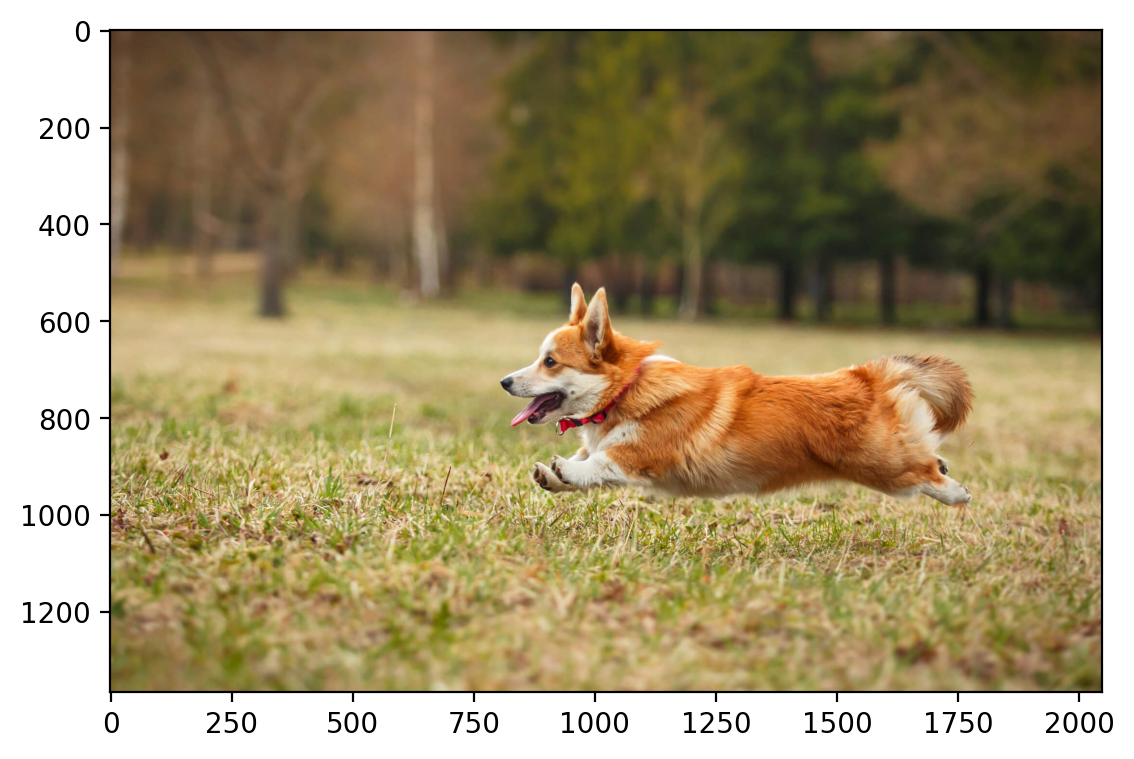

In [ ]:
img_arr = rearrange(img, 'a b c -> b c a').numpy()
print(img_arr.shape)

plt.imshow(img_arr)

In [4]:
from sklearn import preprocessing

scaler_inst = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_inst

MinMaxScaler()

In [5]:
img_scaled = scaler_inst.transform(img.reshape(-1, 1))
img_scaled = img_scaled.reshape(img.shape)

img_scaled = torch.tensor(img_scaled)

print(img_scaled.shape)
print(type(img_scaled))

torch.Size([3, 1365, 2048])
<class 'torch.Tensor'>


In [6]:
img_scaled = img_scaled.to(device)
# Once you've moved a tensor to a specific device using the .to(device) method in PyTorch,
# any subsequent operations you perform on that tensor will also be executed on that device.

In [7]:
cropped_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
cropped_img.shape

# img_scaled.cpu(): This part of the code moves the img_scaled tensor to the CPU. This is necessary because torchvision.transforms.functional.crop operates on CPU tensors
# torchvision.transforms.functional.crop: This function is used to crop a portion of an image. It takes the following arguments: top pixel coordinate, left pixel coordinate, heigth, width

torch.Size([3, 300, 300])

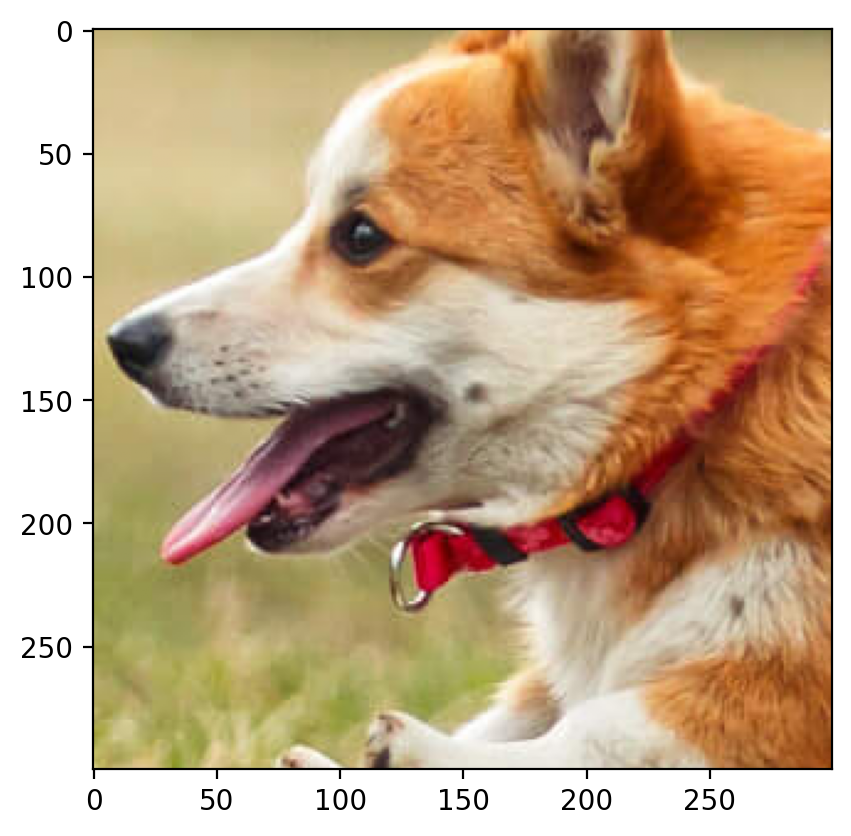

In [ ]:
plt.imshow(rearrange(cropped_img, 'a b c -> b c a').numpy())


In [8]:
cropped_img = cropped_img.to(device)
# moving the cropped_img tensor on 'CUDA' GPU environment


In [9]:
# Get the dimensions of the image tensor
num_channels, height, width = cropped_img.shape
print(num_channels, height, width)

3 300 300


In [ ]:
torch.arange(2).repeat(3,4)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 1, 0, 1]])

In [ ]:
a = torch.tensor([0,1])
b = torch.tensor([2,3])

mat = torch.stack([a, b, a], dim= 0)
mat

tensor([[0, 1],
        [2, 3],
        [0, 1]])

In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()

w_coords = w_coords.reshape(-1)        # Just flattens the matrix and does not make a column vec .reshape(-1,1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
X.shape

torch.Size([12, 2])

In [10]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (height * width, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [11]:
dog_X, dog_Y = create_coordinate_map(cropped_img)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [12]:
# MinMaxScaler from -1 to 1
scaler_X_inst = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X_inst.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [13]:
# We try to create a parameterized relation using a single layer nn between the coordinate map(2) and the image pixels(3)
# We are training a nn so that if we input any (x, y) coord then we should get the corresponding r,g,b pixels at that location

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [14]:
n_inputs, n_outputs = 2, 3

net = LinearModel(n_inputs, n_outputs)
net.to(device)
# you can shift the neural network and its corresponding operations to CUDA using the to() method in PyTorch.


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [15]:
def train_nn(net, lr, X, Y, max_epochs, flag_print=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #  torch.optim.Adam: This is PyTorch's implementation of the Adam optimizer, a popular choice for training neural networks.
    #  Adam is an adaptive optimization algorithm that adjusts the learning rate for each parameter individually, which can lead to faster convergence and better performance.

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = net.forward(X)      # We do a full batch GD here

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if flag_print and epoch % 100 == 0:
            print(f"Epoch {epoch}/{max_epochs} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train_nn(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0/1000 loss: 0.635257
Epoch 100/1000 loss: 0.057969
Epoch 200/1000 loss: 0.036956
Epoch 300/1000 loss: 0.036823
Epoch 400/1000 loss: 0.036823
Epoch 500/1000 loss: 0.036823
Epoch 600/1000 loss: 0.036823
Epoch 700/1000 loss: 0.036823
Epoch 800/1000 loss: 0.036823
Epoch 900/1000 loss: 0.036823


0.03682255372405052

In [16]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape

    net.eval()
    # net.eval(): Sets the neural network to evaluation mode, disabling dropout and batch normalization layers.

    with torch.no_grad():
        # with torch.no_grad():: Disables gradient computation, as it's not needed for inference.
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    # gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]): Defines a grid for two subplots with equal width ratios.

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    # original_img.cpu() moves the tensor to the CPU, and .permute(1, 2, 0) rearranges the dimensions to (height, width, channels) if necessary.
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

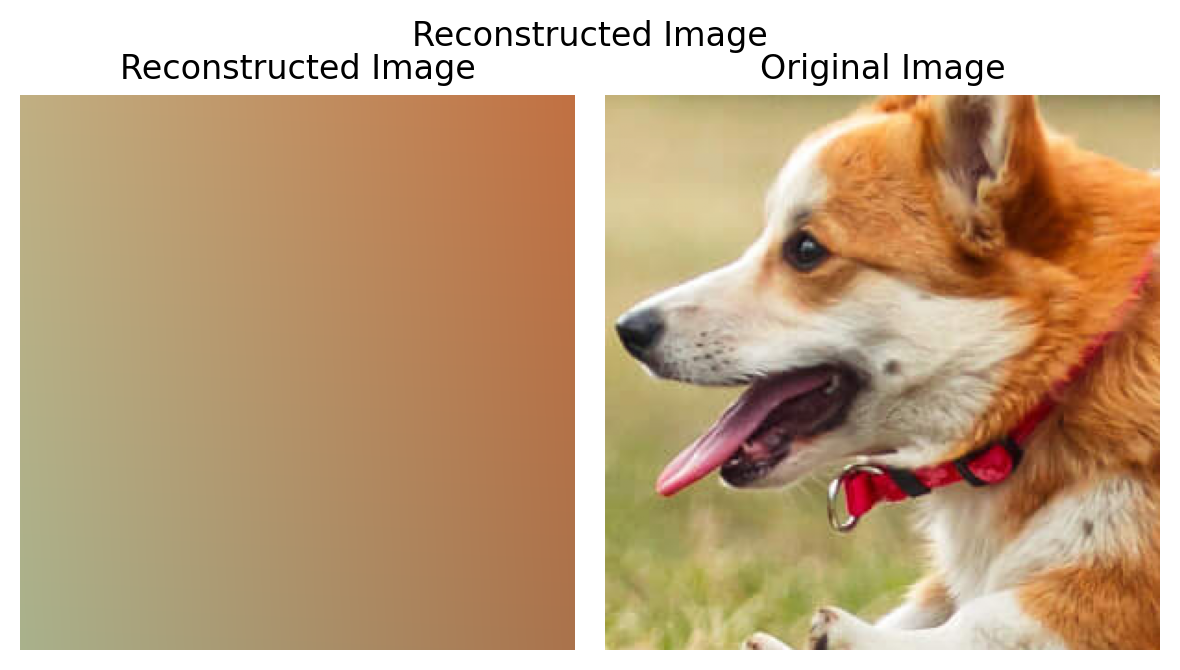

In [ ]:
plot_reconstructed_and_original_image(cropped_img, net, dog_X_scaled, title="Reconstructed Image")

In [ ]:
col_vec1 = torch.arange(5).reshape(-1,1)
col_vec2 = torch.arange(-5,0).reshape(-1,1)

col_vecs = torch.cat([col_vec1, col_vec2], dim=1)

col_vecs_poly = preprocessing.PolynomialFeatures(2).fit_transform(col_vecs)

col_vecs_poly

array([[ 1.,  0., -5.,  0., -0., 25.],
       [ 1.,  1., -4.,  1., -4., 16.],
       [ 1.,  2., -3.,  4., -6.,  9.],
       [ 1.,  3., -2.,  9., -6.,  4.],
       [ 1.,  4., -1., 16., -4.,  1.]])

In [ ]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.reshape(-1,1)
    X2 = X2.reshape(-1,1)

    X = torch.cat([X1, X2], dim=1) # torch.cat concatenates tensors along an existing dimension.

    poly = preprocessing.PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X.cpu())

    X_poly = torch.tensor(X_poly, dtype=torch.float32)
    return X_poly.to(device)

In [ ]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)

In [ ]:
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [ ]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train_nn(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0/1500 loss: 0.364711
Epoch 100/1500 loss: 0.028389
Epoch 200/1500 loss: 0.025111
Epoch 300/1500 loss: 0.024162
Epoch 400/1500 loss: 0.023504
Epoch 500/1500 loss: 0.022985
Epoch 600/1500 loss: 0.022554
Epoch 700/1500 loss: 0.022181
Epoch 800/1500 loss: 0.021856
Epoch 900/1500 loss: 0.021566
Epoch 1000/1500 loss: 0.021312
Epoch 1100/1500 loss: 0.021087
Epoch 1200/1500 loss: 0.020883
Epoch 1300/1500 loss: 0.020720
Epoch 1400/1500 loss: 0.020537


0.020386965945363045

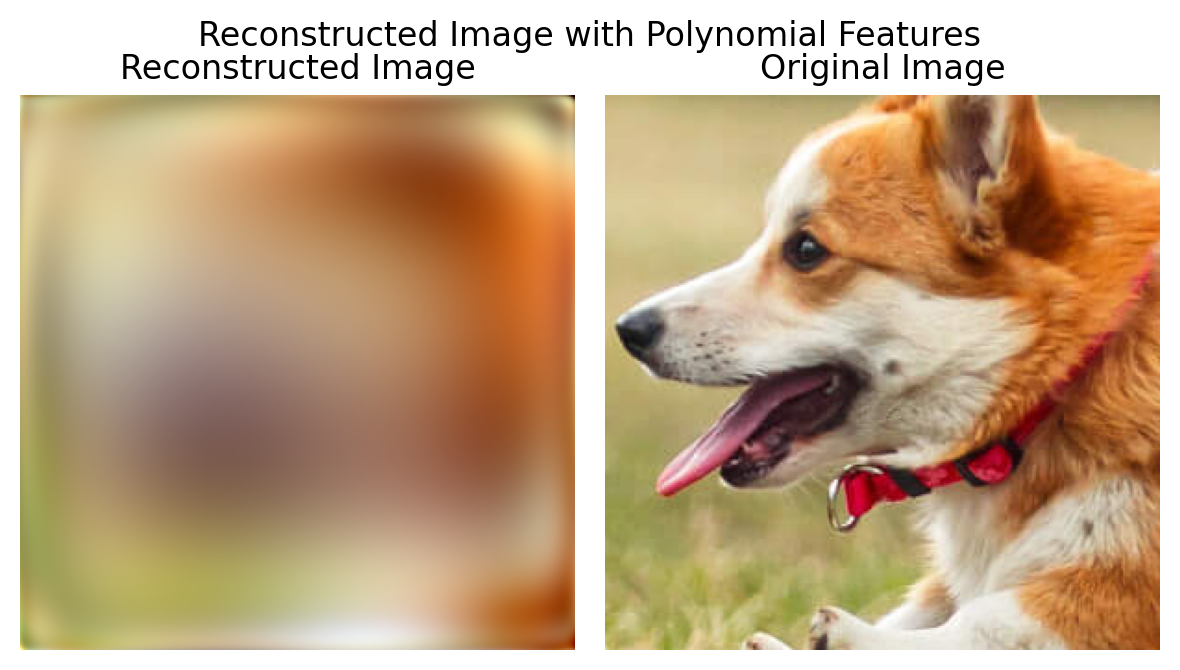

In [ ]:
plot_reconstructed_and_original_image(cropped_img, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

In [19]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler

    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)

    return torch.tensor(X, dtype=torch.float32).to(device)


In [20]:
X_rff = create_rff_features(dog_X_scaled, 5000, 0.008)

In [21]:
X_rff.shape

torch.Size([90000, 5000])

In [22]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train_nn(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0/2500 loss: 0.365249
Epoch 100/2500 loss: 0.062757
Epoch 200/2500 loss: 0.028429
Epoch 300/2500 loss: 0.025060
Epoch 400/2500 loss: 0.023829
Epoch 500/2500 loss: 0.022992
Epoch 600/2500 loss: 0.022360
Epoch 700/2500 loss: 0.021859
Epoch 800/2500 loss: 0.021451
Epoch 900/2500 loss: 0.021108
Epoch 1000/2500 loss: 0.020815
Epoch 1100/2500 loss: 0.020557
Epoch 1200/2500 loss: 0.020328
Epoch 1300/2500 loss: 0.020120
Epoch 1400/2500 loss: 0.019930
Epoch 1500/2500 loss: 0.019754
Epoch 1600/2500 loss: 0.019589
Epoch 1700/2500 loss: 0.019436
Epoch 1800/2500 loss: 0.019292
Epoch 1900/2500 loss: 0.019156
Epoch 2000/2500 loss: 0.019029
Epoch 2100/2500 loss: 0.018911
Epoch 2200/2500 loss: 0.018799
Epoch 2300/2500 loss: 0.018695
Epoch 2400/2500 loss: 0.018599


0.018509458750486374

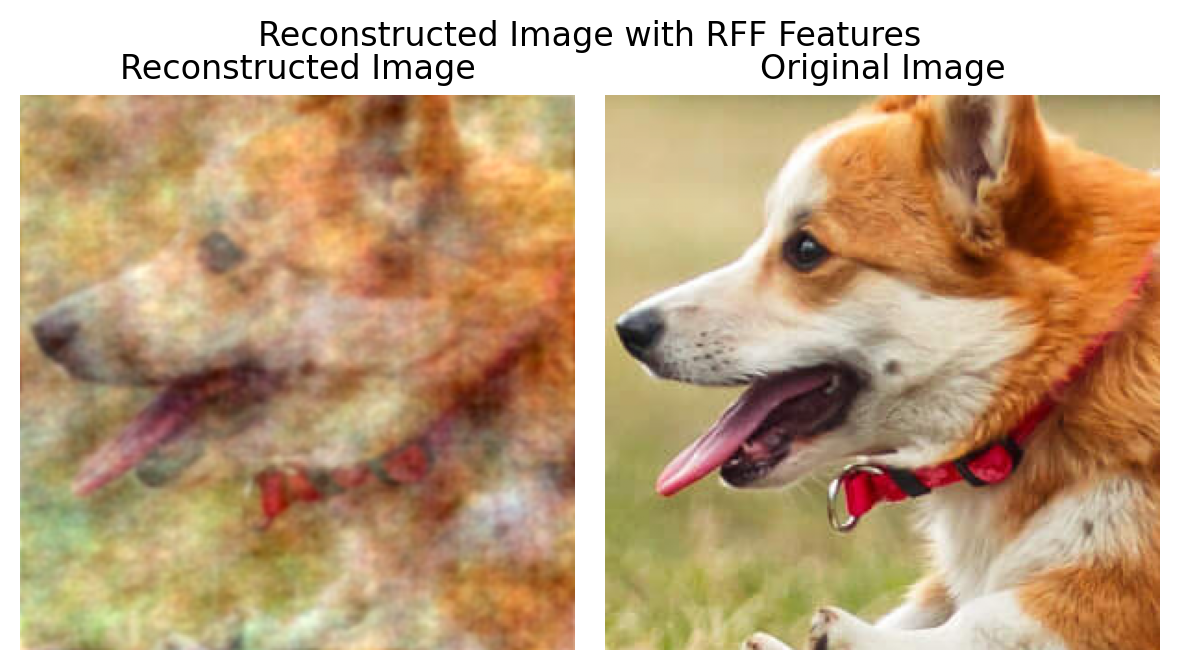

In [23]:
plot_reconstructed_and_original_image(cropped_img, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
w = 100
scale=2
torch.arange(0, w, 1/scale)

tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
         4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
         8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
        12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
        16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
        20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
        24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
        28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
        32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
        36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
        40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
        44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
        48.0000, 48.5000, 49.0000, 49.50